In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Naive Bayes Classification and Cross Validation

## Read in dataframe and show

In [3]:
df = pd.read_csv("fake_bills.csv", sep = ';')
df.dropna(inplace=True)
print(df.shape)
df.head(10)

(1463, 7)


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
5,True,172.17,103.74,104.08,4.42,2.95,112.81
6,True,172.34,104.18,103.85,4.58,3.26,112.81
7,True,171.88,103.76,104.08,3.98,2.92,113.08
8,True,172.47,103.92,103.67,4.00,3.25,112.85
9,True,172.47,104.07,104.02,4.04,3.25,113.45


## Data Description
This dataset was found on Kaggle (https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills) and it classifies bills as either real or fake (is_genuine variable). The independent variables give information about the size of different features of the bill and can be used to predict the genuinness of a bill based on how much deviation these variables have from the standard parameters set by the US mint.

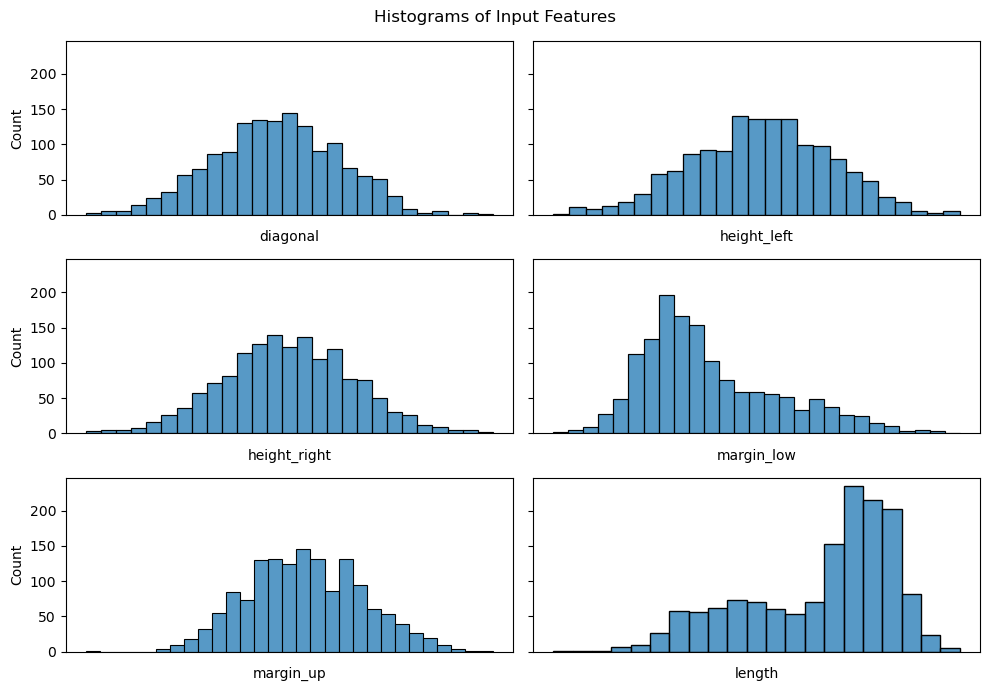

In [4]:
fig, ax = plt.subplots(3, 2, figsize = (10, 7), sharey = True )
dat = df.drop(columns = "is_genuine")
count = 0
colnames = list(dat.columns)
for row in ax:
    for col in row:
        sns.histplot(dat.loc[:, colnames[count]], ax = col)
        col.set(xticklabels = [])
        col.tick_params(bottom=False)
        count += 1
fig.suptitle("Histograms of Input Features")
plt.tight_layout()

plt.show()

All of these features seem to be normally distributed, so we can hypothesize that the Gaussian Naive Bayes Classifier will give us the most accurate results.

## Creating a new KMeans model
First, I will split into 10 subsets so I will be able to easily use cross validation to check that the Gaussian NB is indeed the best fit for this dataset. This can be accomplished manually by splitting into 10 subsets and then iteratively finding the MSE of the 'out' set, or we can use the sklearn 'KFold' method, which is what I will use here.

In addition to this I will perform a "KMeans" fit to try to identify the clusters of fake and real bills and compare it to the two best performing models from my midterm project, which were GaussianNB and the simple KNN.

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from numpy import mean, absolute, sqrt

In [6]:
X = df.drop(columns = 'is_genuine')
y = df.is_genuine

In [35]:
#Define cross-validation split and model
cross = KFold(n_splits = 10, random_state=1, shuffle = True)

#Get cross validation score for Gaussian Model
mod = GaussianNB()
scores = cross_val_score(mod, X, y, scoring='accuracy', cv=cross)
GaussianRMSE = mean(scores)


#Get cross validation RMSE for a more complex KNN Classifier
from sklearn.cluster import KMeans
mod = KMeans(n_clusters = 2, n_init = 3)    
scores = cross_val_score(mod, X, y, scoring='accuracy', cv=cross)
KMeansRMSE = mean(scores)


#Get cross validation RMSE for a more simple KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
mod = KNeighborsClassifier(n_neighbors = 25)
scores = cross_val_score(mod, X, y, scoring='accuracy', cv=cross)
K_simpRMSE = mean(scores)

In [10]:
print(f"NB = {GaussianRMSE}, KMeans = {KMeansRMSE}, SimpKNN = {K_simpRMSE}")

NB = 0.9911098686049762, KMeans = 0.49793588668344047, SimpKNN = 0.989749324387289


## Note
We get a very low cross validation score for the KMeans test, but we should investigate further to see if this test is accurate or not for an unsupervised method.


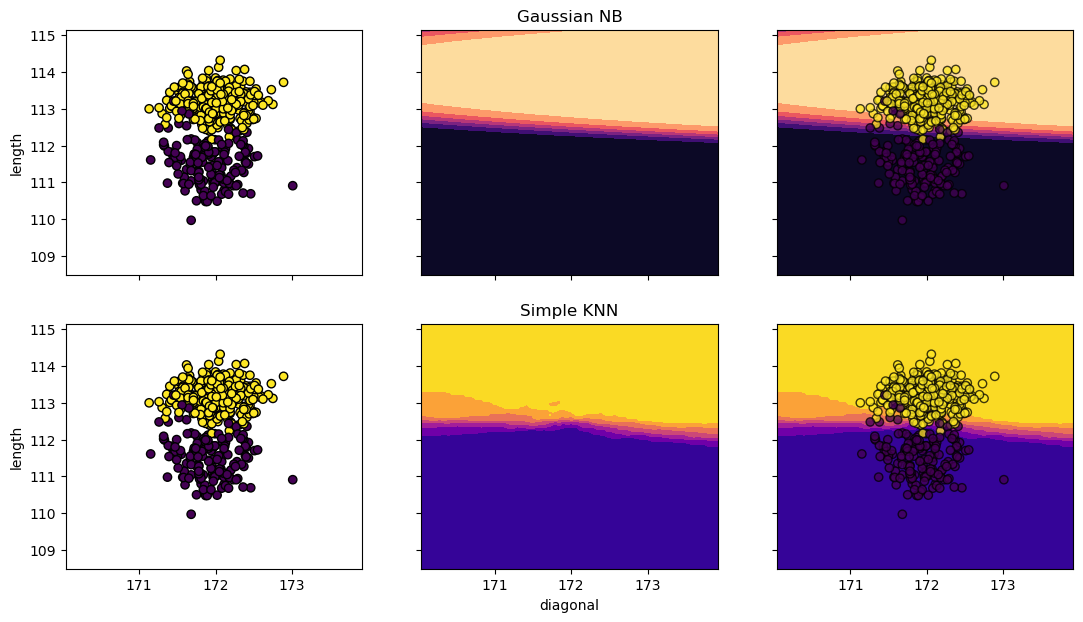

In [30]:
from sklearn.inspection import DecisionBoundaryDisplay
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(columns = 'is_genuine'), df.is_genuine, test_size = 1/3)
X_train_cols = xtrain[["diagonal", 'length'] ]
fig2, ax = plt.subplots(2, 3, figsize = (13, 7), sharey = True , sharex=True)


ax[0,0].scatter(xtest.diagonal, xtest.length, c = ytest, ec = 'k')
ax[1,0].scatter(xtest.diagonal, xtest.length, c = ytest, ec = 'k')
ax[1,0].set_ylabel('length')
ax[0,0].set_ylabel('length')

nb = GaussianNB().fit(X_train_cols, ytrain)
boundary = DecisionBoundaryDisplay.from_estimator(nb, 
                                                  X_train_cols,
                                                  cmap=plt.cm.magma,
                                                  ax = ax[0,1], xlabel= '', ylabel = '')
boundary = DecisionBoundaryDisplay.from_estimator(nb, 
                                                  X_train_cols,
                                                  cmap=plt.cm.magma,
                                                  ax = ax[0,2], xlabel= '', ylabel = '')
ax[0,2].scatter(xtest.diagonal, xtest.length, c = ytest, ec = 'k', alpha = .75)
ax[0,1].set_title("Gaussian NB")

#kmeans = KMeans(n_clusters = 2).fit(X_train_cols)
#boundary2 = DecisionBoundaryDisplay.from_estimator(kmeans, 
#                                                  X_train_cols,
#                                                  cmap=plt.cm.viridis,
#                                                 ax = ax[1,1], xlabel= '', ylabel = '')
#boundary2 = DecisionBoundaryDisplay.from_estimator(kmeans, 
#                                                  X_train_cols,
#                                                  cmap=plt.cm.viridis,
#                                                 ax = ax[1,2], xlabel= '', ylabel = '')

#ax3.scatter(xtest.diagonal, xtest.length, c = ytest, ec = 'k') 
ax[1,1].set_title("Complex KNN")

kn2 = KNeighborsClassifier(n_neighbors=25).fit(X_train_cols, ytrain)
boundary3 = DecisionBoundaryDisplay.from_estimator(kn2, 
                                                  X_train_cols,
                                                  cmap=plt.cm.plasma,
                                                  ax= ax[1,1], ylabel = '')
boundary3 = DecisionBoundaryDisplay.from_estimator(kn2, 
                                                  X_train_cols,
                                                  cmap=plt.cm.plasma,
                                                  ax= ax[1,2], xlabel= '', ylabel = '')
ax[1,2].scatter(xtest.diagonal, xtest.length, c = ytest, ec = 'k', alpha = .75)
ax[1,1].set_title("Simple KNN")
plt.show()

## Plotting KMeans
Since we already know the data can be classified into two categories, we will make our KMeans model with 2 clusters. We can do this to investigate qualitatively how well the model can classify the data.

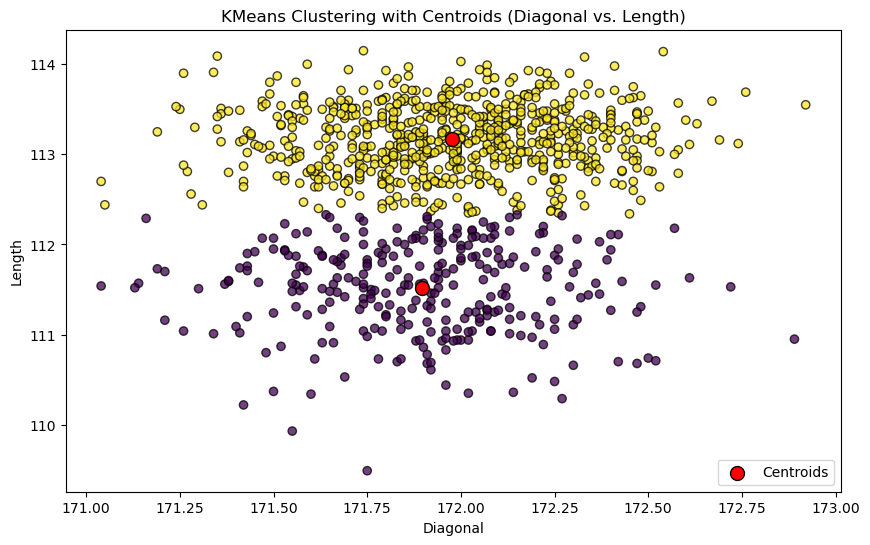

In [75]:
plt.subplots(figsize=(10,6))
kmeans = KMeans(n_clusters=2, random_state=7) 
kmeans.fit(X_train_cols)
#pred = kmeans.predict(xtest)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0] , centroids[:,1] , color = 'red', s= 100, zorder = 1, ec = 'k', label = 'Centroids')
plt.scatter(xtrain.diagonal, xtrain.length, c = kmeans.labels_, ec = 'k', alpha = .75 , zorder=0)
plt.xlabel("Diagonal")
plt.ylabel("Length")
plt.title("KMeans Clustering with Centroids (Diagonal vs. Length)")
plt.legend(loc = 'lower right')
plt.show()

## KMeans Results
We can see in the plot that the centroids (red dots) and the clusters pretty closely follow the predictions from the GaussianNB and the simple KNN classification, so it is likely that a different validation method might be more accurate. We can try a simple Confusion Matrix.

In [70]:
from sklearn.metrics import confusion_matrix
#Get RMSE for Gaussian Model
mod = GaussianNB()
mod.fit(xtrain, ytrain)
pred = mod.predict(xtest)
GaussianCM = confusion_matrix(ytest, pred)


#Get RMSE for a KMeans Classifier
mod = KMeans(n_clusters = 2, random_state=7)
mod.fit(xtrain)
pred = mod.predict(xtest)
KMeansCM = confusion_matrix(ytest, pred)


#Get cross validation RMSE for a more simple KNN Classifier
mod = KNeighborsClassifier(n_neighbors = 25)
mod.fit(xtrain, ytrain)
pred = mod.predict(xtest)
KnnCM = confusion_matrix(ytest, pred)

print(f'GaussianNB Confusion Matrix Results: \n {GaussianCM}')
print(f'KMeans Confusion Matrix Results: \n {KMeansCM}')
print(f'KNN Confusion Matrix Results: \n {KnnCM}')

GaussianNB Confusion Matrix Results: 
 [[157   3]
 [  0 328]]
KMeans Confusion Matrix Results: 
 [[154   6]
 [  1 327]]
KNN Confusion Matrix Results: 
 [[155   5]
 [  0 328]]


# Analysis
The above plots show the model trained and plotted on the 'diagonal' and 'length' features of the dataset. The confusion matrix shows that the TPR and TNR are both very high for all three models. After plotting the KMeans model with the centroids, we could see that the cross validation method used for unsupervised methods was not effective in predicting the model's performance. There are other metrics for KMeans specifically that could've been used to determine accuract such as distance from the centroid. In a future project it would be interesting to investigate how changing parameters of the KMeans model would change its accuracy and using these accuracy metrics specific to a clustering method would be helpful in determining the effect of these model parameter changes.

The results from the confusion matrix and the results of plotting the KMeans model give it just as much credibility for analyzing this dataset as the other two methods have. We could also expect that with optimization, it could predict at an even more accurate rate. Looking at the confusion matrix, we can see no significant variation in the results of the three models. It is likely for a very cut and dry set of data where there are two well established categories, it is very easy for an algorithm to make predictions, especially with an abundance of data which is very particular to the classification outcome. It would be interesting to additionally investigate this model's performance with more qualitative data or input parameters which don't have a direct causal link to the output and perhaps are only correlated slightly.